# Hello World under Uncertainty!
In this notebook, we will use the **FoSRL** library to train a safe policy in a uncertain control-affine system.

We consider a linear dynamical system with additive uncertainty:
$$
\dot{x} = A \, x + B \, u + z
$$

where `x=[px, py]`, `u=[vx, vy]` and `z=[zx, zy]`.

As already shown in the previous tutorial, FoSRL operates in two distinct phases: 

1. An **offline counter-example guided pretraining** phase, where FoSRL is going to build a Control Barrier Function (CBF) to remain within the set of safe states.
2. An **online safe interactive learning** phase, where FoSRL is going to iteratively (and safely) explore the environment, collect the reward signal, and update the policy to maximize the reward collection.

The changes to cope with uncertainty mainly affect the first phase, while the second remains the same as in the previous tutorial.

In [6]:
# Import the necessary libraries
import numpy as np
import torch
from fosco.systems import make_system
from fosco.systems.uncertainty import add_uncertainty
from fosco.config import CegisConfig
from fosco.cegis import Cegis

# plotting utilities
from fosco.plotting.domains import plot_domain
from fosco.plotting.constants import DOMAIN_COLORS
from plotly.graph_objs import Figure

In [7]:
seed = 42
verbosity = 1

# Offline Counter-example guided Pretraining

### Define the symbolic assumptions on the dynamics and uncertainty

To enable the counter-example guided pretraining, 
we need to define a set of **symbolic assumptions** on the environment dynamics
that we use to learn and verify the CBF.

For all systems, 
the assumptions consist of the characterization of the state and spaces,
and sub-domains for initial, unsafe and other states.
Moreover,
since we are considering an uncertain system,
we need to define the uncertainty domain.

Each domain must be a **symbolic set**.
We offer several implementations of common multi-dimensional sets, 
such as:
- Rectangle, Sphere,
- Union, Intersection, Complement,
- and others.

In [8]:
# define control-affine dynamical system
system_id = "SingleIntegrator"
uncertainty_type = "AdditiveBounded"
system = make_system(system_id)()
system = add_uncertainty(uncertainty_type, system=system)
print(type(system))

<class 'fosco.systems.uncertainty.additive_bounded.AdditiveBounded'>


In [9]:
# define state domains and input domains
# and initial, unsafe, lie state domains
domains = system.domains

print("Domains: ", list(domains.keys()), "\n")
for k, dom in domains.items():
    print(f"{k}: {dom}")

# Visualization of state domains
fig = Figure()
for dname, domain in domains.items():
    if dname in DOMAIN_COLORS:        
        color = DOMAIN_COLORS[dname] if dname in DOMAIN_COLORS else None
        fig = plot_domain(domain, fig, color=color, label=dname)
fig.update_traces(showlegend=True)

fig.show()

Domains:  ['lie', 'input', 'init', 'unsafe', 'uncertainty'] 

lie: Rectangle((-5.0, -5.0), (5.0, 5.0))
input: Rectangle((-5.0, -5.0), (5.0, 5.0))
init: Complement(Rectangle((-4.0, -4.0), (4.0, 4.0)))
unsafe: Sphere((0.0, 0.0), 1.0)
uncertainty: Sphere((0.0, 0.0), 1.0)


For this system, there are now five domains:
- `input`: the domain of control actions;
- **`uncertainty`: the domain of the uncertainty.**
- `init`: the domain of initial states, for which we want the CBF to be positive;
- `unsafe`: the domain of unsafe states, for which we want the CBF to be negative;
- `lie`: the domain of all the states, for which we will try to enforce the CBF condition on Lie derivative. 

### Define the numerical data

Having defined the symbolic expressions for the verification of the CBF,
we need their numerical counter-parts to have training data for the learning.

Here, for each of the state domains,
we are going to define a dataset of samples:
- `init`: a dataset of initial states;
- `unsafe`: a dataset of unsafe states;
- `lie`: a dataset of (state, action) pairs.

Note: we do not directly define the training data,
because the tool expects to get generator functions for each of them.

In [10]:
# data generator
from fosco.common.consts import DomainName as dn

data_gen = {
    'init': lambda n: domains[dn.XI.value].generate_data(n),
    'unsafe': lambda n: domains[dn.XU.value].generate_data(n),
    'lie': lambda n: torch.concatenate([
        domains["lie"].generate_data(n), 
        domains["input"].generate_data(n),
        domains["uncertainty"].generate_data(n),
    ], dim=1
    ),
    'uncertainty': lambda n: torch.concatenate([
        domains["lie"].generate_data(n),
        domains["input"].generate_data(n),
        domains["uncertainty"].generate_data(n),
    ],
    dim=1,
    )
}

### Define the configuration

It remains to define the configuration of the pretraining and its hyper-parameters.

There are two important changes to the configuration:
- the `CERTIFICATE` is now set to `rcbf` to indicate we are looking for a Robust CBF;
- the `LOSS_WEIGHTS` includes the uncertainty loss term and an additional regularization term.

In [15]:
config = CegisConfig(
    SEED=seed,              # the seed for reproducibility
    CERTIFICATE="rcbf",      # the type of certificate, either cbf or rcbf
    VERIFIER="z3",          # the type of verifier, either z3 or dreal
    ACTIVATION=["htanh"],   # the activation of the i-th hidden layer
    N_HIDDEN_NEURONS=[20],  # the nr of neurons of the i-th hidden layer
    CEGIS_MAX_ITERS=20,     # the maximum number of iterations
    N_DATA=5000,            # the nr of samples in each training dataset
    RESAMPLING_N=100,       # the nr of points to sample around each counter-example
    RESAMPLING_STDDEV=0.1,  # the std deviation to sample around each counter-example    
    LOSS_WEIGHTS={          # the weights for each loss term
        'init': 1.0, 
        'unsafe': 1.0, 
        'lie': 1.0,
        'robust': 1.0,
        'conservative_b': 1.0,
        'conservative_sigma': 0.1        
    },
)

Let us spend some words on the loss weights.

For finding a candidate CBF, we minimize the following loss

$$
\mathcal{L} = \lambda_{init} \, \mathcal{L}_{init} + \lambda_{unsafe} \, \mathcal{L}_{unsafe} + \lambda_{lie} \, \mathcal{L}_{lie} + \lambda_{robust} \, \mathcal{L}_{robust} + \lambda_{reg-b} \, \mathcal{L}_{reg-b} + \lambda_{reg-s} \, \mathcal{L}_{reg-s}
$$

where:
- $\mathcal{L}_{init}$ penalizes counter-examples in the dataset of initial states; 
- $\mathcal{L}_{unsafe}$ penalizes counter-examples in the dataset of unsafe states; 
- $\mathcal{L}_{lie}$ penalizes counter-examples in the lie dataset;
- $\mathcal{L}_{robust}$ penalizes counter-examples in the robust dataset;
- $\mathcal{L}_{reg-b}$ penalizes states where the CBF is negative, to discourage overconservative CBF functions.
- $\mathcal{L}_{reg-s}$ penalizes states where the compensator is positive, to discourage overconservative compensator functions.

In [16]:
from fosco.plotting.functions import plot_torch_function

cegis = Cegis(
    system=system,
    domains=domains,
    config=config,
    data_gen=data_gen,
    verbose=verbosity
)

result = cegis.solve()


fig = plot_torch_function(
    function=result.barrier, 
    domains=system.domains
)
fig.show()

fig = plot_torch_function(
    function=result.compensator, 
    domains=system.domains
)
fig.show()

INFO:fosco.cegis:Seed: 42
INFO:fosco.cegis:Iteration 1
INFO:fosco.verifier.verifier:init: Counterexample Found: [x0, x1] = tensor([-5.0000, -0.4178]), [] = tensor([])
INFO:fosco.consolidator.consolidator:Dataset sizes: init: 5101, unsafe: 5000, lie: 5000, uncertainty: 5000
INFO:fosco.cegis:
INFO:fosco.cegis:Iteration 2
INFO:fosco.verifier.verifier:init: Counterexample Found: [x0, x1] = tensor([-4.1111,  5.0000]), [] = tensor([])
INFO:fosco.consolidator.consolidator:Dataset sizes: init: 5202, unsafe: 5000, lie: 5000, uncertainty: 5000
INFO:fosco.cegis:
INFO:fosco.cegis:Iteration 3
INFO:fosco.verifier.verifier:init: Counterexample Found: [x0, x1] = tensor([5.0000, 0.2408]), [] = tensor([])
INFO:fosco.consolidator.consolidator:Dataset sizes: init: 5303, unsafe: 5000, lie: 5000, uncertainty: 5000
INFO:fosco.cegis:
INFO:fosco.cegis:Iteration 4
INFO:fosco.verifier.verifier:uncertainty: Counterexample Found: [x0, x1, u0, u1, z0, z1] = tensor([ 1.8438, -0.6293,  0.0000, -0.5975,  0.0000,  0.83

# Online Safe Interactive Learning

Starting from the Robust CBF found in the previous phase,
we can now proceed with the policy training.

### Gymnasium Wrapper

As common in RL libraries, we adopt the `gymnasium` api to simulate the system.

To make the continuous-time CBF formulation to work in discretized simulation,
we use a small time step.

In [18]:
import gymnasium as gym
from fosco.systems.gym_env.system_env import SystemEnv
from fosco.systems.gym_env.rewards import GoToUnsafeReward
from rl_trainer.wrappers.record_episode_statistics import RecordEpisodeStatistics

max_steps = 100
sim_dt = 0.1
num_envs = 3

def make_env(seed, render_mode=None):

    def thunk():
        env = SystemEnv(
            system=system,
            dt=sim_dt,
            max_steps=max_steps,
            reward_fn=GoToUnsafeReward(system=system),
            render_mode=render_mode
        )
        env.action_space.seed(seed)
        env = RecordEpisodeStatistics(env)
        env = gym.wrappers.NormalizeReward(env)
        env = gym.wrappers.TransformReward(env, lambda reward: np.clip(reward, -10, 10))
        return env

    return thunk
    
envs = gym.vector.SyncVectorEnv(
        [
            make_env(seed=seed) for i in range(num_envs)
        ]
    )

### Define Safe Policy

In [19]:
from rl_trainer.ppo.ppo_config import PPOConfig

config = PPOConfig()
config.num_envs = num_envs
config.num_steps = 256
config.total_timesteps = 100000

In [20]:
from rl_trainer.safe_ppo.safeppo_trainer import SafePPOTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = SafePPOTrainer(envs=envs, config=config, barrier=result.barrier, compensator=result.compensator, device=device)

/home/luigi/anaconda3/envs/fosco-robust/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.system to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.system` for environment variables or `env.get_wrapper_attr('system')` that will search the reminding wrappers.




### Training

In [21]:
results = trainer.train(envs=envs, verbose=verbosity)

INFO:rl_trainer.ppo.ppo_trainer:iteration 1/130
INFO:rl_trainer.ppo.ppo_trainer:SPS: 65
INFO:rl_trainer.ppo.ppo_trainer:iteration 2/130
INFO:rl_trainer.ppo.ppo_trainer:SPS: 68
INFO:rl_trainer.ppo.ppo_trainer:iteration 3/130
INFO:rl_trainer.ppo.ppo_trainer:Last 10 episodes: 
	global step: 1536/100000 
	episodic returns: -547.07 +/- 87.74 
	episodic costs: 0.00 +/- 0.00 
	episodic lengths: 100.00 +/- 0.00 

INFO:rl_trainer.ppo.ppo_trainer:SPS: 69
INFO:rl_trainer.ppo.ppo_trainer:iteration 4/130
INFO:rl_trainer.ppo.ppo_trainer:Last 10 episodes: 
	global step: 2304/100000 
	episodic returns: -467.65 +/- 81.53 
	episodic costs: 0.00 +/- 0.00 
	episodic lengths: 100.00 +/- 0.00 

INFO:rl_trainer.ppo.ppo_trainer:SPS: 70
INFO:rl_trainer.ppo.ppo_trainer:iteration 5/130
INFO:rl_trainer.ppo.ppo_trainer:Last 10 episodes: 
	global step: 3072/100000 
	episodic returns: -533.83 +/- 77.10 
	episodic costs: 0.00 +/- 0.00 
	episodic lengths: 100.00 +/- 0.00 

INFO:rl_trainer.ppo.ppo_trainer:SPS: 70
INFO:

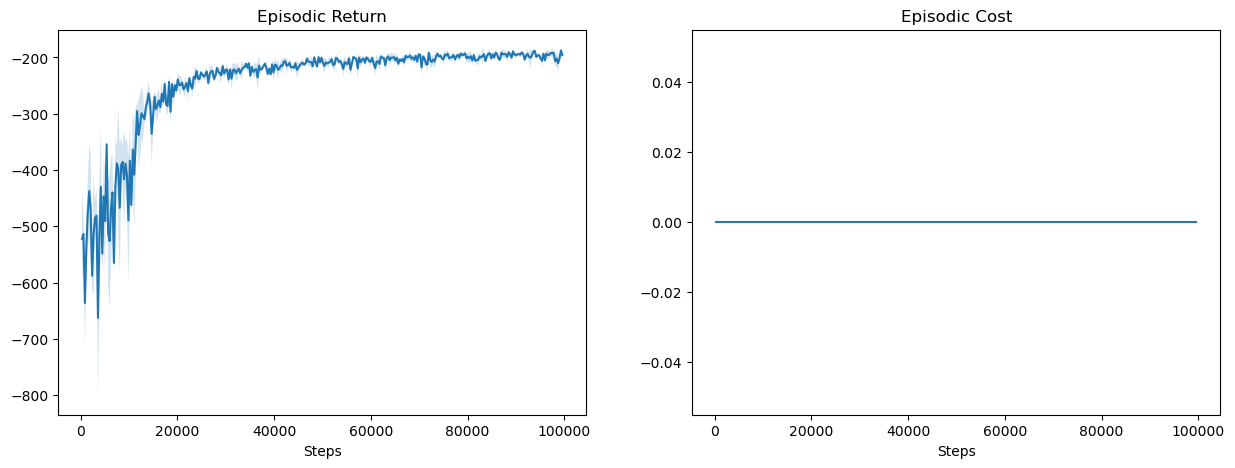

In [22]:
import matplotlib.pyplot as plt

train_steps = results["train_steps"]
train_returns = results["train_returns"]
train_costs = results["train_costs"]

# group by steps (possible duplicate in steps due to vectorization)
train_steps, train_returns, train_returns_std, train_costs, train_costs_std = zip(*sorted(
    [(step, 
      np.mean([r for r, s in zip(train_returns, train_steps) if s == step]), 
      np.std([r for r, s in zip(train_returns, train_steps) if s == step]),
      np.mean([c for c, s in zip(train_costs, train_steps) if s == step]),
      np.std([c for c, s in zip(train_costs, train_steps) if s == step])) for step in set(train_steps)]
))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_steps, train_returns)
axes[0].fill_between(train_steps, np.array(train_returns) - np.array(train_returns_std), np.array(train_returns) + np.array(train_returns_std), alpha=0.2)
axes[0].set_xlabel("Steps")
axes[0].set_title("Episodic Return")

axes[1].plot(train_steps, train_costs)
axes[1].fill_between(train_steps, np.array(train_costs) - np.array(train_costs_std), np.array(train_costs) + np.array(train_costs_std), alpha=0.2)
axes[1].set_xlabel("Steps")
axes[1].set_title("Episodic Cost")

plt.show()

In [24]:
eval_envs = gym.vector.SyncVectorEnv([make_env(seed=seed, render_mode='rgb_array') for i in range(1)])
agent = trainer.get_actor()

obs, infos = eval_envs.reset()
done = False
frames = []
while not done:
    action = agent.get_action_and_value(torch.Tensor(obs).to(device))["action"]
    obs, reward, term, trunc, infos = eval_envs.step(action.detach().cpu().numpy())
    done = term[0] or trunc[0]
    frame = eval_envs.envs[0].render()
    frames.append(frame)

In [25]:
# save gif
import imageio
imageio.mimsave("safe_robust_policy.mp4", frames, fps=10)

<video controls src="safe_policy.mp4">animation</video>

In [26]:
from IPython.display import Video

Video("safe_robust_policy.mp4")